In [1]:
import pandas as pd
import os
import urllib
from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA
import numpy as np
from scipy.signal import periodogram
import statsmodels.api as sm
import dask.dataframe as dd

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from matplotlib import pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import PredefinedSplit
import warnings
warnings.filterwarnings('ignore')

# Theoretic part 

Multiple choice questions: please select all that applies and explain your answer.

### Question 1 (Autocorrelation).
The autocorrelation plot of the daily time-series has local peaks at t=7,14,21,28 etc.. How would you interpret that?

A. The time-series reaches its maximum on the days 7,14,21,28...

B. The time-series reaches its minimum on the days 7,14,21,28...

C. The time-series is likely to have a periodic pattern with a period of 7 days

D. The time-series is likely to have 7 periods per day

E. The appropriate AR model for the time-series should have at least 7 terms.

Your answer:C

There is a cyclic pattern of about 7-day cycles in the sequence. It does not mean that the maximum or minimum is necessarily reached on these days, nor does it imply that a cycle occurs during the day, so A, B,D are incorrect.The number of terms in the AR model is not directly determined from the cycle, so E is incorrect. C Correct

### Question 2 (Stationarity).

Which of the following time-series models are always stationary:

A. Linear trend

B. MA model

C. White noise

D. Random walk

E. ARMA(1,2) model

F. ARIMA(1,1,1) model

Your answer:B, C, E

A: Not smooth, with a trend term.
B: Moving average models are always smooth.
C: White noise is always a smooth series.
D: random wandering is non-smooth.
E: is an ARMA model that has satisfied the smoothness requirement is always smooth.
F: There is a difference term, which is a treatment model for non-smooth series and is not itself a smooth model.

### Question 3 (PCA).
Which of the following statements regarding the model dimensionality reduction through Principal Component Analysis (PCA) are true:

A. Leading principal components of the features are the most efficient for modeling the output variable.

B. Principal components of the standardized features are uncorrelated and this way less exposed to multicollinearity.

C. The model using principal components of the features can't overfit.

D. Feature selection based on the principal components of the features is often more efficient in preventing overfitting comparered the feature selection over the original features.

E. Principal components are harder to interpret compared to the original features making the PCA regresssion model less interpretable compared to the regression model using original features.

Your answer:B, D, E

A is incorrect: While the principal components explain the variance of the input variables, they are not necessarily most closely related to the OUTPUT..


C is incorrect: Overfitting is still possible using principal components, although the likelihood of overfitting is usually reducersion)

### Question 4 (MapReduce).

What is true about MapReduce:

A. MapReduce is a Python module enabling parallel computing

B. Using MapReduce approach makes the code more suitable for parallel computing.

C. MapReduce code always runs faster compared to the code using more traditional approaches, like loops or list comprehensions.

D. MapReduce code will always efficiently run on multiple cores of your CPU or multiple machines within your cluster if available.

E. Multiprocessing and PySpark efficient alternatives to MapReduce.



Your answer: B, E

A is incorrect: MapReduce is not a Python module, but a framework.

Cis incorrectr: MapReduce is not guaranteed to always be faster; in simple scenarios, traditional methods may be more efficient.

D is incorrect: The efficiency of MapReduce depends on the specific hardware and software environment and implementation; it is not always possible to effectively and efficiently utilise multiple cores or multiple nodes.

# Practice part: Taxi ridership from JFK to other taxi zones prediction.
This project is an example of applying PCA to predict hourly yellow taxi ridership at the taxi zone level. Modeling taxi ridership at a fine spatial and temporal granularity is challenging due to the low signal-to-noise ratio and high dimensionality. In this case, dimension reduction essential in feature engineering. This project has five steps: data downloading, data preprocessing, baseline modeling, feature engineering, and RandomForest modeling.

Let's start with data downloading.

## 1. Data downloading
Design a function to download yellow taxi data from 2017-01-01 to 2018-12-31 at https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page.

In [13]:
dataDir = 'taxidata'
if os.path.exists(dataDir):
    pass
else:
    os.mkdir(dataDir)
Years = [2017,2018]
Months = range(1,13)
VehicleTypes = ['yellow']

def getUrl(cabtype,year,month):
    baseUrl = 'https://d37ci6vzurychx.cloudfront.net/trip-data/'

    month = str(month).zfill(2)
    fileName = '%s_tripdata_%s-%s.parquet'%(cabtype,year,month)

    return baseUrl + fileName, fileName

In [14]:
for year in Years:
    for month in Months:
        for cabtype in VehicleTypes:
            url, fileName = getUrl(cabtype,year,month)

            print("Downloading: "+str(fileName))

            if fileName in os.listdir(dataDir):
                print("file exists")
                continue

            filePath = os.path.join(dataDir, fileName)
            try:
                urllib.request.urlretrieve(url, filePath)
            except:
                # if fails remove the incomplete file
                os.remove(filePath)
                try:
                    # start again after a delay of 2 min
                    time.sleep(60*2)
                    urllib.request.urlretrieve(url, filePath)
                except:
                    print("Download this file later!")
                    pass

Downloading: yellow_tripdata_2017-01.parquet
file exists
Downloading: yellow_tripdata_2017-02.parquet
file exists
Downloading: yellow_tripdata_2017-03.parquet
file exists
Downloading: yellow_tripdata_2017-04.parquet
file exists
Downloading: yellow_tripdata_2017-05.parquet
file exists
Downloading: yellow_tripdata_2017-06.parquet
file exists
Downloading: yellow_tripdata_2017-07.parquet
file exists
Downloading: yellow_tripdata_2017-08.parquet
file exists
Downloading: yellow_tripdata_2017-09.parquet
file exists
Downloading: yellow_tripdata_2017-10.parquet
file exists
Downloading: yellow_tripdata_2017-11.parquet
file exists
Downloading: yellow_tripdata_2017-12.parquet
file exists
Downloading: yellow_tripdata_2018-01.parquet
file exists
Downloading: yellow_tripdata_2018-02.parquet
file exists
Downloading: yellow_tripdata_2018-03.parquet
file exists
Downloading: yellow_tripdata_2018-04.parquet
file exists
Downloading: yellow_tripdata_2018-05.parquet
file exists
Downloading: yellow_tripdata_20

In [15]:
# Check the column structure of individual files  
sample_2017 = pd.read_parquet("taxidata/yellow_tripdata_2017-01.parquet")  
sample_2018 = pd.read_parquet("taxidata/yellow_tripdata_2018-01.parquet")  

print("2017 Columns:", sample_2017.columns.tolist())  
print("2018 Columns:", sample_2018.columns.tolist())  

# Verify if there are trip records in the JFK area  
jfk_records = dd.read_parquet("taxidata/*.parquet")[lambda df: df.PULocationID == 132]  
print("Number of JFK trips:", jfk_records.shape[0].compute())  

# Retrieve all unique zone IDs that have appeared  
all_zones = dd.read_parquet("taxidata/*.parquet").DOLocationID.unique().compute()  
print("Range of actual zone IDs:", min(all_zones), "-", max(all_zones))  

2017 Columns: ['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime', 'passenger_count', 'trip_distance', 'RatecodeID', 'store_and_fwd_flag', 'PULocationID', 'DOLocationID', 'payment_type', 'fare_amount', 'extra', 'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge', 'total_amount', 'congestion_surcharge', 'airport_fee']
2018 Columns: ['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime', 'passenger_count', 'trip_distance', 'RatecodeID', 'store_and_fwd_flag', 'PULocationID', 'DOLocationID', 'payment_type', 'fare_amount', 'extra', 'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge', 'total_amount', 'congestion_surcharge', 'airport_fee']
Number of JFK trips: 11387984
Range of actual zone IDs: 1 - 265


## 2. Data Preprocessing
Use dask to aggregate all months' records into one dataframe, and aggregate dataset by date and hour to get the ridership from JFK to each taxi zone each hour. The expected output has columns: date, hour, drop-off location 1, drop-off location 2, etc.

Hint:
1. JFK taxi zone id is 132.
2. time column should be the pickup time, and ridership is passenger count.
3. Try read_parquet("*.parquet") to read all parquet file in a folder
4. files in 2017 and 2018 have different columns; apply argument usecols to select desired columns.
5. using .compute() function to convert processed dask dataframe to pandas dataframe for further modeling.

### 2.1 Data loadin

In [18]:
#your answer here
# Define the data directory  
dataDir = 'taxidata'  

# Read all Parquet files, selecting the necessary columns  
cols_to_use = ['tpep_pickup_datetime', 'passenger_count', 'PULocationID', 'DOLocationID']  
dask_df = dd.read_parquet(os.path.join(dataDir, '*.parquet'), usecols=cols_to_use)  

# Determine the zone ID for JFK  
jfk_id = 132  

# Filter records for rides originating from JFK (PULocationID == 132)  
jfk_rides = dask_df[dask_df.PULocationID == jfk_id]  

# Aggregate data by date and hour, calculating the number of passengers per hour  
jfk_rides['pickup_date'] = jfk_rides['tpep_pickup_datetime'].dt.date  
jfk_rides['pickup_hour'] = jfk_rides['tpep_pickup_datetime'].dt.hour  

# Aggregate passenger data for each hour  
aggregated_rides = jfk_rides.groupby(['pickup_date', 'pickup_hour']).agg(  
    ridership=('passenger_count', 'sum')  
).reset_index()  

# Convert Dask DataFrame to Pandas DataFrame  
final_df = aggregated_rides.compute()  
print(final_df.head())  

  pickup_date  pickup_hour  ridership
0  2017-01-01            0      527.0
1  2017-01-01            1      247.0
2  2017-01-01            2      105.0
3  2017-01-01            3       76.0
4  2017-01-01            4       46.0


### 2.2 Sanity check
Then, we need to do some basic sanity checks. It is possible that in a particular hour, completely dispatched no yellow taxis from JFK. Check does each day has 24-hour records and add missing records back to the dataframe. The final output should have 17520 rows ($365\times2\times24$)

In [20]:
# Define the data directory  
dataDir = 'taxidata'  

# Read all Parquet files, selecting the necessary columns  
cols_to_use = ['tpep_pickup_datetime', 'passenger_count', 'PULocationID']  
dask_df = dd.read_parquet(os.path.join(dataDir, '*.parquet'), usecols=cols_to_use)  

# Determine the zone ID for JFK  
jfk_id = 132  

# Filter records for rides originating from JFK (PULocationID == 132)  
jfk_rides = dask_df[dask_df.PULocationID == jfk_id]  

# Aggregate data by date and hour, calculating the number of passengers per hour  
jfk_rides['pickup_date'] = jfk_rides['tpep_pickup_datetime'].dt.date  
jfk_rides['pickup_hour'] = jfk_rides['tpep_pickup_datetime'].dt.hour  

# Aggregate passenger data for each hour  
aggregated_rides = jfk_rides.groupby(['pickup_date', 'pickup_hour']).agg(  
    ridership=('passenger_count', 'sum')  
).reset_index()  

# Convert Dask DataFrame to Pandas DataFrame  
final_df = aggregated_rides.compute()  

# Ensure the pickup_date column is of datetime type  
final_df['pickup_date'] = pd.to_datetime(final_df['pickup_date'])  

# Generate all combinations of dates and hours for completeness  
dates = pd.date_range(start='2017-01-01', end='2018-12-31', freq='D')  
hours = range(24)  

# Create a DataFrame with all possible date and hour combinations  
full_index = pd.MultiIndex.from_product(  
    [dates, hours], names=['pickup_date', 'pickup_hour']  
).to_frame(index=False)  

# Set the index of the DataFrame being processed  
final_df.set_index(['pickup_date', 'pickup_hour'], inplace=True)  

# Merge back missing records, filling ridership with 0  
full_ridership = full_index.merge(final_df, on=['pickup_date', 'pickup_hour'], how='left').fillna(0)  

# The result should have 17520 rows  
print("Final record count:", len(full_ridership))  
print(full_ridership.head(10))  

# Save the result to a CSV file for further analysis  
full_ridership.to_csv('jfk_ridership_by_hour.csv', index=False)  

Final record count: 17520
  pickup_date  pickup_hour  ridership
0  2017-01-01            0      527.0
1  2017-01-01            1      247.0
2  2017-01-01            2      105.0
3  2017-01-01            3       76.0
4  2017-01-01            4       46.0
5  2017-01-01            5      309.0
6  2017-01-01            6      409.0
7  2017-01-01            7      314.0
8  2017-01-01            8      463.0
9  2017-01-01            9      313.0


## 3. Time-series exploratory analysis
Apply exploratory analysis over the daily aggregated dataset at first.

### 3.1 aggregate the ridership from each dropoff location and sum it to get daily records.

In [23]:
# Aggregate by pickup_date to summarize daily ridership  
daily_ridership = full_ridership.groupby('pickup_date').agg(  
    daily_passengers=('ridership', 'sum')  
).reset_index()  

# View the aggregated DataFrame  
print(daily_ridership.head())  

  pickup_date  daily_passengers
0  2017-01-01           14710.0
1  2017-01-02           16723.0
2  2017-01-03           16072.0
3  2017-01-04           14549.0
4  2017-01-05           12239.0


### 3.2 Period detection and report the strongest period length on the 2017 data.
Hint: using periodogram or acf plot.

<Figure size 1200x600 with 0 Axes>

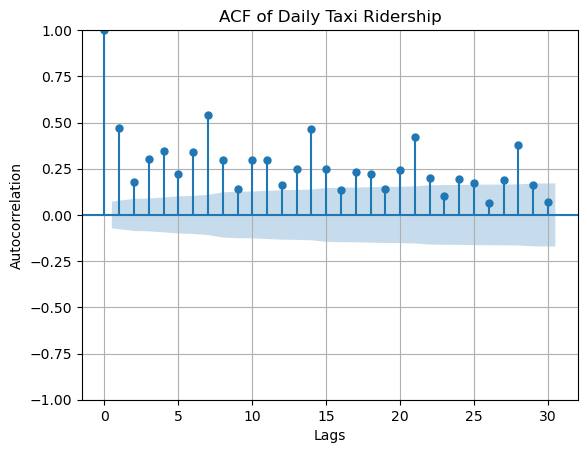

In [25]:
# Set pickup_date as the index  
daily_ridership.set_index('pickup_date', inplace=True)  

# Plot the autocorrelation graph  
plt.figure(figsize=(12, 6))  
plot_acf(daily_ridership['daily_passengers'], lags=30)  
plt.title("ACF of Daily Taxi Ridership")  
plt.xlabel("Lags")  
plt.ylabel("Autocorrelation")  
plt.grid()  
plt.show()  

### 3.3 Trend, seasonality, noise decomposition (using additive model) on 2017 data, .

<Figure size 1200x1000 with 0 Axes>

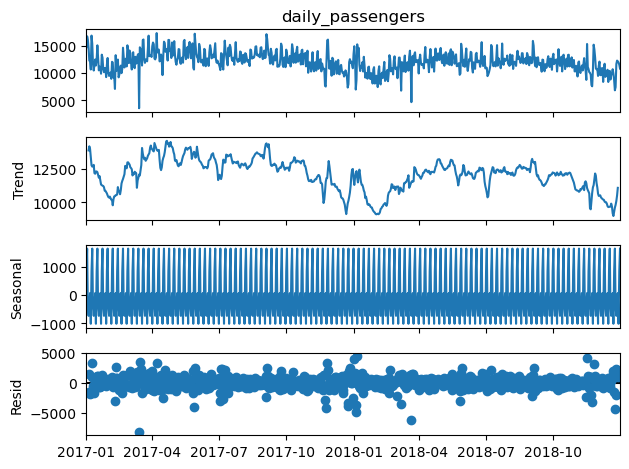

In [27]:
from statsmodels.tsa.seasonal import seasonal_decompose  

# Decompose using the additive model  
decomposition = seasonal_decompose(daily_ridership['daily_passengers'], model='additive')  

# Plot the decomposition results  
plt.figure(figsize=(12, 10))  
decomposition.plot()  
plt.show()  

## 4. Predict the total daily ridership from JFK using ARIMA.
ARIMA is a common method to predict taxi ridership. Before we predict taxi zone level hourly ridership, let's try to predict the aggregated daily ridership using ARIMA.

### 4.1 Using adfuller test to test the stability of the aggregated dataset. If not stable, apply differencing method until the p-value from adfuller test is smaller than 0.05.

In [30]:
#your answer here
from statsmodels.tsa.stattools import adfuller  

# Perform the ADF test  
adf_result = adfuller(daily_ridership['daily_passengers'])  

# Extract the p-value  
adf_p_value = adf_result[1]  

print("ADF test p-value:", adf_p_value)  

# Check stationarity  
if adf_p_value < 0.05:  
    print("The data is stationary.")  
else:  
    print("The data is non-stationary and requires differencing.")  

ADF test p-value: 0.22346034224891043
The data is non-stationary and requires differencing.


In [31]:
# Perform differencing  
daily_ridership['diff'] = daily_ridership['daily_passengers'].diff()  

# Perform the ADF test on the differenced data  
adf_result_diff = adfuller(daily_ridership['diff'].dropna())  
adf_p_value_diff = adf_result_diff[1]  

print("ADF test p-value after differencing:", adf_p_value_diff)  

# Check stationarity  
if adf_p_value_diff < 0.05:  
    print("The differenced data is stationary.")  
else:  
    print("The differenced data is still non-stationary and requires further differencing.")  

ADF test p-value after differencing: 8.084534561150301e-13
The differenced data is stationary.


### 4.2 build an ARIMA model using terms [P=0, D=1, Q=1], training on the first 700 days, forecast on the last 31 days. Print ARIMA model results and plot in-sample and out-of-sample prediction in different colors.

                               SARIMAX Results                                
Dep. Variable:       daily_passengers   No. Observations:                  700
Model:                 ARIMA(0, 1, 1)   Log Likelihood               -6146.809
Date:                Wed, 19 Mar 2025   AIC                          12297.618
Time:                        03:05:59   BIC                          12306.718
Sample:                    01-01-2017   HQIC                         12301.136
                         - 12-01-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.8936      0.016    -56.012      0.000      -0.925      -0.862
sigma2      2.514e+06   1.01e+05     24.986      0.000    2.32e+06    2.71e+06
Ljung-Box (L1) (Q):                  27.15   Jarque-

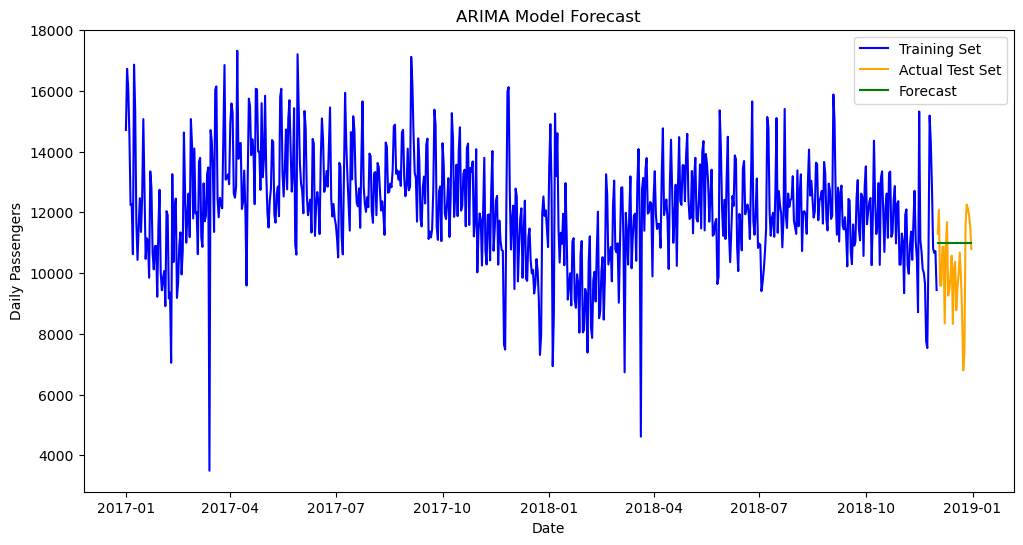

In [41]:
P = 0  
D = 1  
Q = 1  

# Number of training samples  
N = 700  
from statsmodels.tsa.arima.model import ARIMA  
# Split data into training and test sets  
train = daily_ridership['daily_passengers'][:N]  
test = daily_ridership['daily_passengers'][N:N + 31]  

# Build ARIMA model  
model = ARIMA(train, order=(P, D, Q))  
model_fit = model.fit()  

# Print model summary  
print(model_fit.summary())  

# Generate forecasts  
forecast = model_fit.forecast(steps=len(test))  

# Plot the results  
plt.figure(figsize=(12, 6))  
plt.plot(train.index, train, label='Training Set', color='blue')  
plt.plot(test.index, test, label='Actual Test Set', color='orange')  
plt.plot(test.index, forecast, label='Forecast', color='green')  
plt.title("ARIMA Model Forecast")  
plt.xlabel("Date")  
plt.ylabel("Daily Passengers")  
plt.legend()  
plt.show()  

# Taxi zone level prediction

This project aims to predict hourly yellow taxi ridership volume from JFK to each taxi zone. The ARIMA experiment in section 3 forecasts the total ridership amount from JFK. However, based on the reported $R^2$, this model is not a good fit. ARIMA model has four main shortcomings: 1) they rely heavily on stationarity assumption which does not hold in real-world traffic systems 2) they do not consider spatial and structural dependencies that traffic networks exhibit and forecast each sensor as an individual time series 3) they are unable to model non-linear temporal dynamics 4) they suffer from the curse of dimensionality. Due to the limitation of ARIMA, we need to apply another method to predict taxi zone level ridership.

## 5. Feature engineering

Our workflow is first standardizing the dataset, then using PCA to compress the dataset. As we predict future ridership, PCA should be learned from historical data (2017) then apply to the following year (2018). Next, add lag features (PCA components) from the past 12 hours and apply a Random Forest regressor to predict each PCA component's values in the next hour. After we had the PCA component prediction, inverse PCA, and inverse standardization to retrieve taxi ridership prediction in its original scale and dimension, in other words, we are predicting the PCA components instead of taxi zone level ridership and then using the inverse PCA method to reconstruct

In [45]:
#your answer here

### 5.1. standardization.
The standardscaler stores information of this standardization process, including the mean and standard deviation values required when converting the prediction back to the raw scale. Split the whole dataset into two parts: 2017 and 2018, standardize each separately.

In [48]:
#your answer here

# Load data  
data_2017 = pd.read_csv('jfk_ridership_by_hour.csv', parse_dates=['pickup_date'])  
data_2018 = pd.read_csv('jfk_ridership_by_hour.csv', parse_dates=['pickup_date'])  

# Separate features and target variable  
X_2017 = data_2017[['pickup_hour', 'ridership']]  
X_2018 = data_2018[['pickup_hour', 'ridership']]  

# Create StandardScaler object  
scaler = StandardScaler()  

# Fit and transform 2017 data  
X_2017_scaled = scaler.fit_transform(X_2017)  

# Transform 2018 data  
X_2018_scaled = scaler.transform(X_2018)  

# View the scaled data  
print("First few rows of scaled 2017 data:", X_2017_scaled[:5])  
print("First few rows of scaled 2018 data:", X_2018_scaled[:5])  

First few rows of scaled 2017 data: [[-1.66132477  0.07941086]
 [-1.51686175 -0.8939534 ]
 [-1.37239873 -1.38758813]
 [-1.2279357  -1.48840085]
 [-1.08347268 -1.59268988]]
First few rows of scaled 2018 data: [[-1.66132477  0.07941086]
 [-1.51686175 -0.8939534 ]
 [-1.37239873 -1.38758813]
 [-1.2279357  -1.48840085]
 [-1.08347268 -1.59268988]]


### 5.2. PCA

Train PCA on the standardized 2018 dataset. Set PCA components as 5, and gamma is None, use kernel ‘linear’. Report the mean squared error between the standardized data and reconstructed data. Hint: fit the PCA on 2017 data and apply it to transform 2018 data. (5 pts)

In [51]:
from sklearn.decomposition import PCA  
from sklearn.metrics import mean_squared_error  

# Create PCA object with 2 components  
pca = PCA(n_components=2)  

# Fit PCA on the scaled 2017 data  
pca.fit(X_2017_scaled)  

# Transform the 2017 data  
X_2017_pca = pca.transform(X_2017_scaled)  

# Transform the 2018 data  
X_2018_pca = pca.transform(X_2018_scaled)  

# Reconstruct the 2018 data using inverse transform  
X_2018_reconstructed = pca.inverse_transform(X_2018_pca)  

# Calculate the reconstruction error (Mean Squared Error)  
mse = mean_squared_error(X_2018_scaled, X_2018_reconstructed)  

print("Reconstruction Error (MSE):", mse)  

Reconstruction Error (MSE): 9.52263588711991e-33


### 5.3 Add lag
add 12 lags of each component (pca_comps=5) (compressed 2018 data only). The expected output should have 65 dimensions. In the further modeling step, we will apply the 60 lag variables to predict the 5 components.

In [54]:
#your answer here
# Convert 2018 PCA results to DataFrame  
pca_df = pd.DataFrame(X_2018_pca, columns=[f'PCA_component_{i+1}' for i in range(X_2018_pca.shape[1])])  

# Add lag features  
for i in range(1, 13):  # Add lag features for the past 12 time steps  
    for col in pca_df.columns:  
        pca_df[f'{col}_lag_{i}'] = pca_df[col].shift(i)  

# Drop rows with missing values (due to lag features)  
pca_df.dropna(inplace=True)  

# Check the shape of the resulting data  
print("Shape of data after adding lag features:", pca_df.shape)  
print(pca_df.head())  

Shape of data after adding lag features: (17442, 8192)
    PCA_component_1  PCA_component_2  PCA_component_1_lag_1  \
78        -0.677745         0.445913              -1.342805   
79        -0.246207         0.673150              -0.677745   
80        -0.566852         0.148203              -0.246207   
81        -0.592524        -0.081770              -0.566852   
82        -0.463333        -0.156881              -0.592524   

    PCA_component_2_lag_1  PCA_component_1_lag_2  PCA_component_2_lag_2  \
78              -0.014845              -1.884958              -0.352697   
79               0.445913              -1.342805              -0.014845   
80               0.673150              -0.677745               0.445913   
81               0.148203              -0.246207               0.673150   
82              -0.081770              -0.566852               0.148203   

    PCA_component_1_lag_1_lag_2  PCA_component_2_lag_1_lag_2  \
78                    -1.957612                    

## 6. RandomForest modeling

We aim at predicting compressed daily ridership (5 PCA components values) from 12-hour lag variables. Parameter tuning is required in this section, including min_samples_split, min_samples_leaf, and n_estimators. First 80% days for training, test on the rest 20%. And in the training dataset, validate the model on the bottom 20%.


### 6.1 train test split
Please keep in mind that random train test split is not applicable in this case.

In [57]:
# Calculate training set size (first 80% of data)  
train_size = int(len(pca_df) * 0.8)  

# Training set  
X_train_full = pca_df.iloc[:train_size].drop(['PCA_component_1', 'PCA_component_2'], axis=1)  
y_train_full = pca_df.iloc[:train_size][['PCA_component_1', 'PCA_component_2']]  

# Test set  
X_test = pca_df.iloc[train_size:].drop(['PCA_component_1', 'PCA_component_2'], axis=1)  
y_test = pca_df.iloc[train_size:][['PCA_component_1', 'PCA_component_2']]  

# Validation set (bottom 20% of training set)  
val_size = int(len(X_train_full) * 0.2)  
X_val = X_train_full.iloc[-val_size:]  
y_val = y_train_full.iloc[-val_size:]  

# Training set  
X_train = X_train_full.iloc[:-val_size]  
y_train = y_train_full.iloc[:-val_size]  

# Check the shapes of training, validation, and test sets  
print(f"Training features shape: {X_train.shape}, Training target shape: {y_train.shape}")  
print(f"Validation features shape: {X_val.shape}, Validation target shape: {y_val.shape}")  
print(f"Test features shape: {X_test.shape}, Test target shape: {y_test.shape}")  

Training features shape: (11163, 8190), Training target shape: (11163, 2)
Validation features shape: (2790, 8190), Validation target shape: (2790, 2)
Test features shape: (3489, 8190), Test target shape: (3489, 2)


### 6.2 model performance measurement
Use the RandomForest model with the provided parameters (min_samples_split: 2, min_samples_leaf: 10, and n_estimators equal to 50.) to predict the compressed daily ridership. Prediction results are PCA components instead of taxi zone level ridership. To reconstruct the data back to its original size and scale, we need to inverse PCA and inverse standardization. report the taxi zone level R² value.




In [59]:
# Create a Random Forest Regressor  
rf_model = RandomForestRegressor(  
    n_estimators=50,  
    min_samples_split=2,  
    min_samples_leaf=10,  
    random_state=42  
)  

# Train the model  
rf_model.fit(X_train, y_train)  

# Predict on the validation set  
y_val_pred = rf_model.predict(X_val)  

# Predict on the test set  
y_test_pred = rf_model.predict(X_test)  

# Calculate R² scores  
r2_val = r2_score(y_val, y_val_pred)  
r2_test = r2_score(y_test, y_test_pred)  

print("Validation set R² score:", r2_val)  
print("Test set R² score:", r2_test)  

Validation set R² score: 0.8691844056445871
Test set R² score: 0.8759718413348996
